# Implementing the Black-Scholes formula 

In [27]:
import numpy as np
import math
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [28]:
def integrand(x):
    return (1/np.sqrt(2*np.pi)) * np.exp(-(x**2)/2)

In [29]:
def f(y):
    res, err = integrate.quad(integrand, -np.inf, y)
    return res

In [30]:
def d1(s,K,r,d,sigma,T,t):
    val = (np.log(s/K) + (r - d + (sigma**2)/2)*(T-t))/(sigma*np.sqrt(T-t))
    return val

In [31]:
def d2(s,K,r,d,sigma,T,t):
    val = d1(s,K,r,d,sigma,T,t) - sigma*np.sqrt(T-t)
    return val

In [32]:
def theoretical_C(s,K,r,d,sigma,T,t):
    val = s*f(d1(s,K,r,d,sigma,T,t))*np.exp(-d*(T-t)) - K*f(d2(s,K,r,d,sigma,T,t))*np.exp(-r*(T-t))
    return val

Example of a curve with different underlying asset prices:

In [33]:
def payoff_call(s, K):
    if s>K:
        return s-K
    else:
        return 0

In [34]:
S_list = np.linspace(1,80,1000)

call_prices = []
for s in S_list:
    call_prices.append(theoretical_C(s, 45, 0.05, 0.03, 0.4, 1, 0))

payoff = []
for s in S_list:
    payoff.append(payoff_call(s, 45))

Text(0.5, 1.0, 'Call price with BS formula')

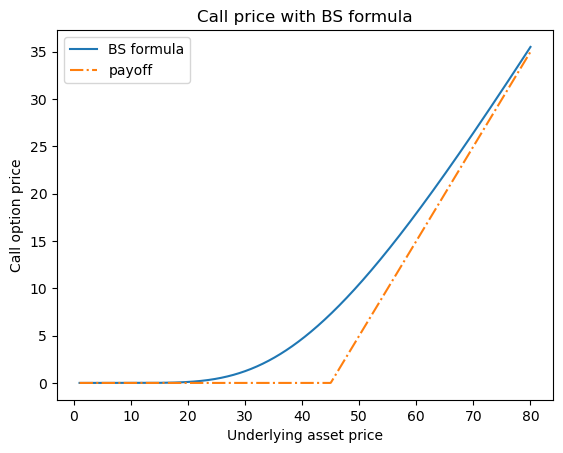

In [35]:
plt.plot(S_list, call_prices, label="BS formula")
plt.plot(S_list, payoff,"-.",label="payoff")
plt.legend()
plt.xlabel("Underlying asset price")
plt.ylabel("Call option price")
plt.title("Call price with BS formula")

# Solving the BS PDE with the Crank-Nicolson scheme

The BS PDE is defined in a domain $D=[0,T]\times [0,S]$: the time-share value domain.  
Here, we define $T=1$ and $S=80$ as before.

In [36]:
T_max = 1
S_max = 80

To simplify the implementation, we also define the other variables as above.

In [65]:
K = 45
r = 0.05
d = 0.03
sigma = 0.4

In [84]:
M = 199 #number of share value intervals
h = S_max/(M+1) #constant share value step

In [93]:
k = 0.005
N = int(T_max/k) #number of time points
N

200

In [94]:
S_mesh = [i*h for i in range(M+2)]
t_mesh = [n*k for n in range(N+1)]

In [109]:
A = [[0 for i in range(M+2)] for i in range(M+2)]

for i in range(M+2): #diagonal of b
    A[i][i] = k/2 * (-r - sigma**2 * S_mesh[i]**2 / h**2) + 1
for i in range(M+1): #diagonal of a
    A[i][i+1] = k/2 * ((r-d)*S_mesh[i]/(2*h) + sigma**2 * S_mesh[i]**2 / (2*h**2))
for i in range(M+1): #diagonal of c
    A[i+1][i] = k/2 * (-(r-d)*S_mesh[i]/(2*h) + sigma**2 * S_mesh[i]**2 / (2*h**2))

In [110]:
B = [[0 for i in range(M+2)] for i in range(M+2)]

for i in range(M+2): #diagonal of e
    B[i][i] = -k/2 * (-r - sigma**2 * S_mesh[i]**2 / h**2) + 1
for i in range(M+1): #diagonal of d
    B[i][i+1] = -k/2 * ((r-d)*S_mesh[i]/(2*h) + sigma**2 * S_mesh[i]**2 / (2*h**2))
for i in range(M+1): #diagonal of f
    B[i+1][i] = -k/2 * (-(r-d)*S_mesh[i]/(2*h) + sigma**2 * S_mesh[i]**2 / (2*h**2))

In [111]:
#initialize C
C = [0 for i in range(M+2)]
for i in range(M+2):
    if S_mesh[i] - K > 0:
        C[i] = S_mesh[i] - K

Text(0, 0.5, 'Call Value')

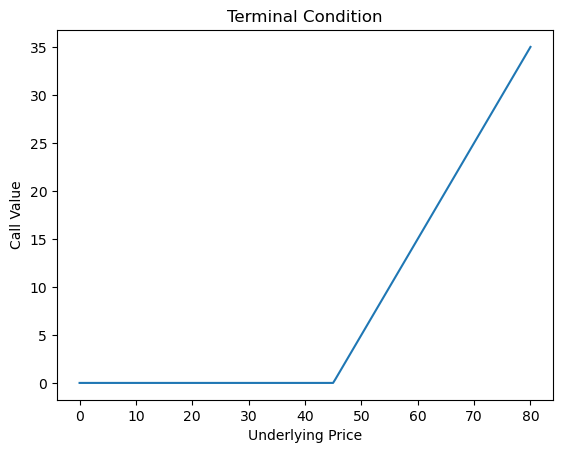

In [112]:
CN_list = [C]
plt.title("Terminal Condition")
plt.plot(S_mesh,CN_list[0])
plt.xlabel("Underlying Price")
plt.ylabel("Call Value")

In [113]:
for n in range(N+1):
    old_C = CN_list[-1]
    aux = np.matmul(np.linalg.inv(B),A)
    new_C = np.matmul(aux,old_C)
    new_C[0] = 0
    new_C[-1] = S_max * np.exp(d*(t_mesh[n]-T_max)) - K*np.exp(r*(t_mesh[n]-T_max))
    CN_list.append(new_C)



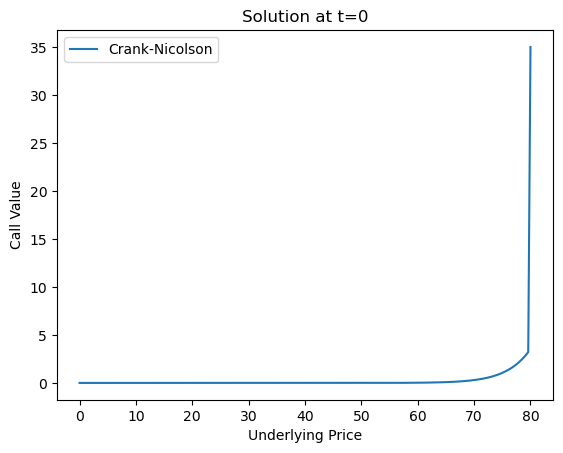

In [114]:
plt.plot(S_mesh,CN_list[-1],"-",label="Crank-Nicolson")
plt.title("Solution at t=0")
plt.xlabel("Underlying Price")
plt.ylabel("Call Value")
plt.legend()

This does not work because of the convection and diffusion terms, as they both depend on $S$.  
So, we transform our variable $s$ into its logarithm.

In [228]:
A = 6
M_z = 99
h = A/(M_z+1) #constant share value step

In [229]:
Z_mesh = [i*h for i in range(-M_z-2, M_z+2)]

In [230]:
A = [[0 for i in range(2*M_z+4)] for i in range(2*M_z+4)]

for i in range(2*M_z+4): #diagonal of b
    A[i][i] = k/2 * (-r- sigma**2 / h**2) + 1
for i in range(2*M_z+3): #diagonal of a
    A[i][i+1] = k/2 * ((r-d-sigma**2 / 2)/(2*h) + sigma**2 / (2*h**2))
for i in range(2*M_z+3): #diagonal of c
    A[i+1][i] = k/2 * (-(r-d - sigma**2 / 2)/(2*h) + sigma**2 / (2*h**2))

In [231]:
B = [[0 for i in range(2*M_z+4)] for i in range(2*M_z+4)]

for i in range(2*M_z+4): #diagonal of b
    B[i][i] = k/2 * (r + sigma**2 / h**2) + 1
for i in range(2*M_z+3): #diagonal of a
    B[i][i+1] = -k/2 * ((r-d-sigma**2 / 2)/(2*h) + sigma**2 / (2*h**2))
for i in range(2*M_z+3): #diagonal of c
    B[i+1][i] = -k/2 * (-(r-d - sigma**2 / 2)/(2*h) + sigma**2 / (2*h**2))

In [232]:
#initialize C
C = [0 for i in range(2*M_z+4)]
for i in range(2*M_z+4):
    if np.exp(Z_mesh[i]) - K > 0:
        C[i] = np.exp(Z_mesh[i]) - K
CN_list = [C]

In [233]:
for n in range(N+1):
    old_C = CN_list[-1]
    aux = np.matmul(np.linalg.inv(B),A)
    new_C = np.matmul(aux,old_C)
    new_C[0] = 0
    new_C[-1] = 0
    CN_list.append(new_C)

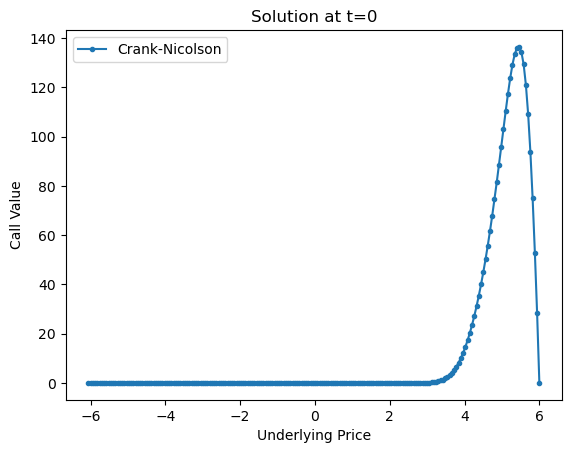

In [234]:
plt.plot(Z_mesh,CN_list[-1],".-",label="Crank-Nicolson")
plt.title("Solution at t=0")
plt.xlabel("Underlying Price")
plt.ylabel("Call Value")
plt.legend()

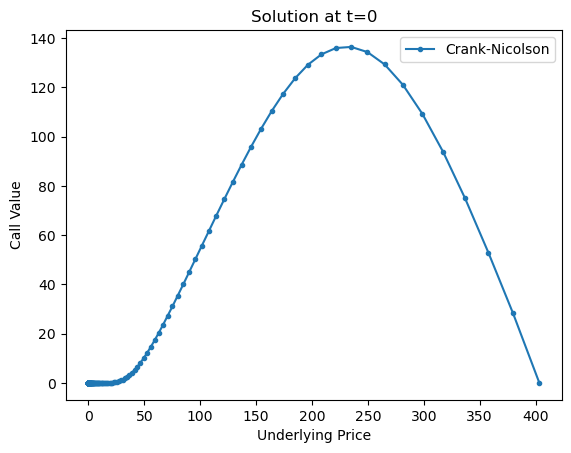

In [235]:
CN_array = (np.array(CN_list[-1]))
S_array = np.exp(np.array(Z_mesh))
plt.plot(S_array,CN_array,".-",label="Crank-Nicolson")
plt.title("Solution at t=0")
plt.xlabel("Underlying Price")
plt.ylabel("Call Value")
plt.legend()

In [236]:
def last(S):
    for i in range(len(S_array)):
        if S_array[i]>S:
            break
    return i

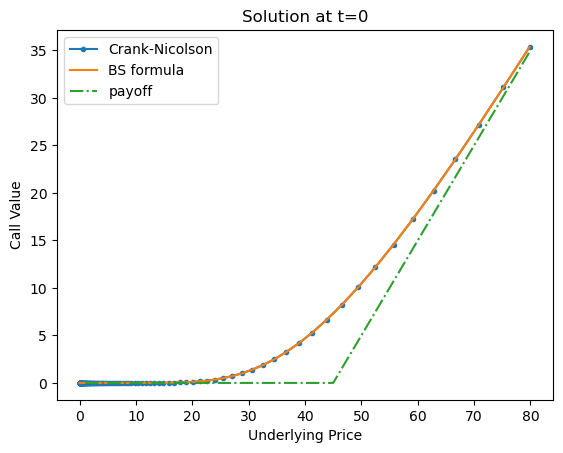

In [238]:
plt.plot(S_array[:last(80)],CN_array[:last(80)],".-",label="Crank-Nicolson")
call_prices = []
for s in S_array[:last(80)]:
    call_prices.append(theoretical_C(s, 45, 0.05, 0.03, 0.4, 1, 0))
plt.plot(S_array[:last(80)], call_prices, label="BS formula")
plt.plot(S_list, payoff,"-.",label="payoff")
plt.title("Solution at t=0")
plt.xlabel("Underlying Price")
plt.ylabel("Call Value")
plt.legend()

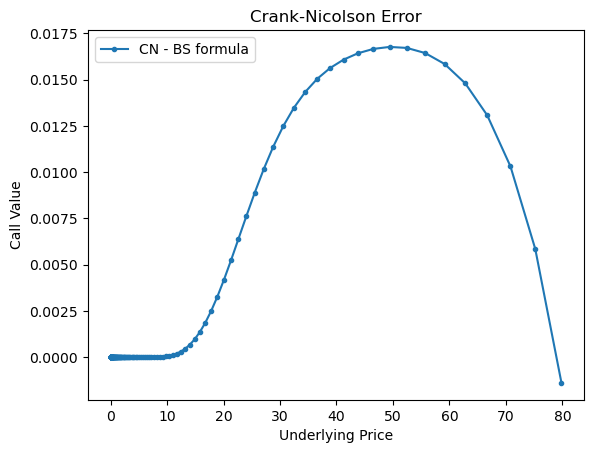

In [239]:
call_prices_array = np.array(call_prices)
diff = CN_array[:last(80)] - call_prices_array
plt.plot(S_array[:last(80)],diff,".-",label="CN - BS formula")
plt.title("Crank-Nicolson Error")
plt.xlabel("Underlying Price")
plt.ylabel("Call Value")
plt.legend()